In [10]:
import os

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd

from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from keras.models import model_from_json
from IPython.display import display, Image

from utils import get_class, load_data_sources, reset_seeds, get_positive_samples
from constants import protein_list, protein_names, experiment_set

#Set random seeds for reproducibility.
reset_seeds()


1_PARCLIP_AGO1234_hg19
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


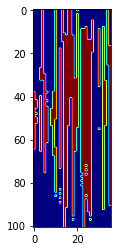

In [2]:
training_set_number = 0
for protein in protein_list:
    print (protein)
            
    #Load the model and weights.
    with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
        json = json_file.read()
        model = model_from_json(json)
        model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))

    #Load data for testing purposes.
    data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)

    #We are interested in the last dense layer of the network.
    layer_index = -1
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)
    
    # seed_input = np.random.rand(1,101,int(sum(data_matrix_dim[protein])))

    #We generate the input that maximizes the filter output activation. 
    activation = visualize_activation(model, layer_index, filter_indices = 1 ,input_range = (0,2))
                                                            
    with open ("results/set_%s/%s/activation_maximization" % (training_set_number, protein), "wb") as activation_maximization_f:
        np.save(activation_maximization_f, activation)
    
    plt.figure()
    plt.imshow(activation, cmap = 'jet')
    plt.show()

In [3]:
for protein in protein_list:
    print(protein)

    with open(
        "results/set_%s/%s/activation_maximization"
        % (training_set_number, protein),
        "rb",
    ) as activation_maximization_f:
        activation = np.load(activation_maximization_f)

        nucleotides = {
            "A": activation[:, 0],
            "T": activation[:, 1],
            "G": activation[:, 2],
            "C": activation[:, 3],
        }
        position_count = np.sum(activation[:, 0:4], 1)

        for entry in nucleotides:
            nucleotides[entry] = np.nan_to_num(
                np.true_divide(nucleotides[entry], position_count)
            )

        with open(
            "results/set_%s/%s/max_activation_sequences.txt"
            % (training_set_number, protein),
            "w",
        ) as sequences_f:
            sequences_f.write("P0 A U G C\n")

        for i in range(len(nucleotides["A"])):
            with open(
                "results/set_%s/%s/max_activation_sequences.txt"
                % (training_set_number, protein),
                "a",
            ) as sequences_f:
                sequences_f.write(
                    "P{} {} {} {} {}\n".format(
                        i + 1,
                        nucleotides["A"][i],
                        nucleotides["T"][i],
                        nucleotides["G"][i],
                        nucleotides["C"][i],
                    )
                )



1_PARCLIP_AGO1234_hg19
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


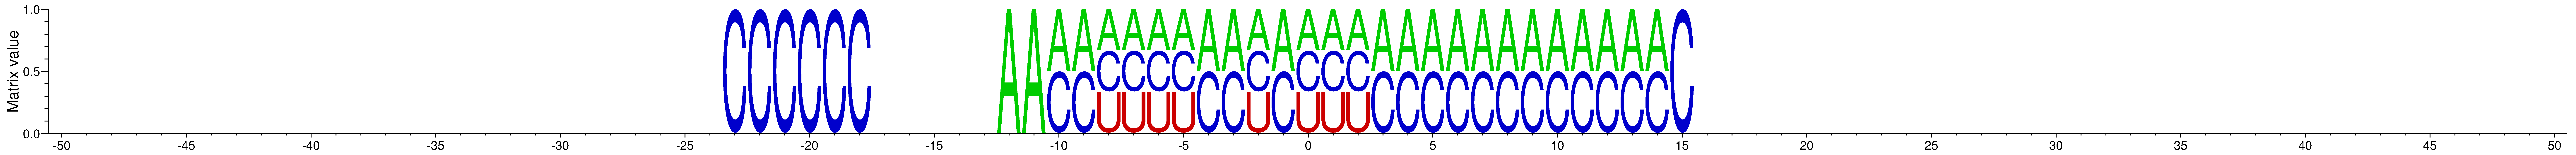

In [4]:

for protein in protein_list:
    cmd = (
        f"weblogo -f results/set_0/{protein}/max_activation_sequences.txt -D transfac -F png_print -o results/set_0/{protein}/max_activation.png "
        "--errorbars NO --show-xaxis YES --show-yaxis YES --first-index '-50' -A rna --composition none -n 101 --color '#00CC00' 'A' 'A' --color "
        "'#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' --size large -P '' --ylabel 'Matrix value' --yaxis 1 --units 'probability'"
    )
    os.system(cmd)

    display(
        Image(f"results/set_0/{protein}/max_activation.png")
    )

In [22]:
%run first_layer_filters

1_PARCLIP_AGO1234_hg19


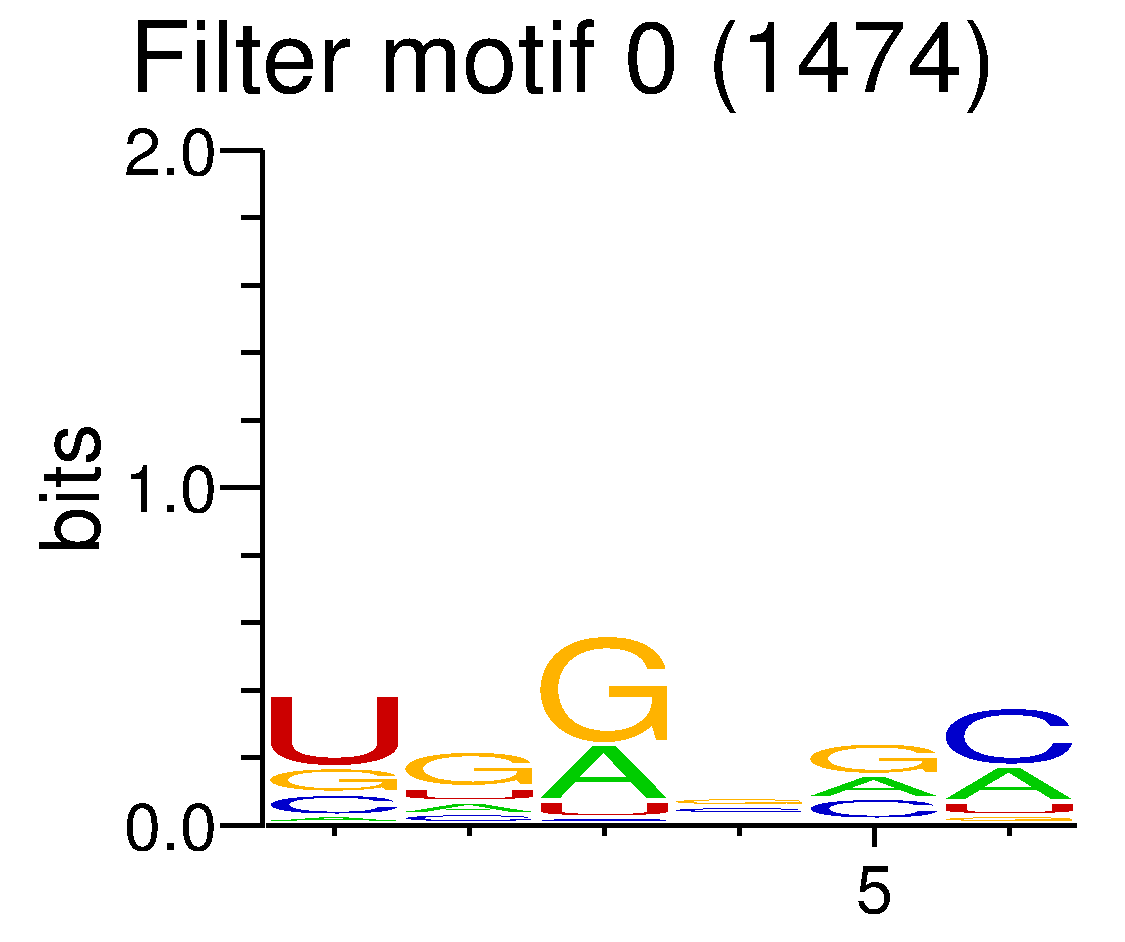

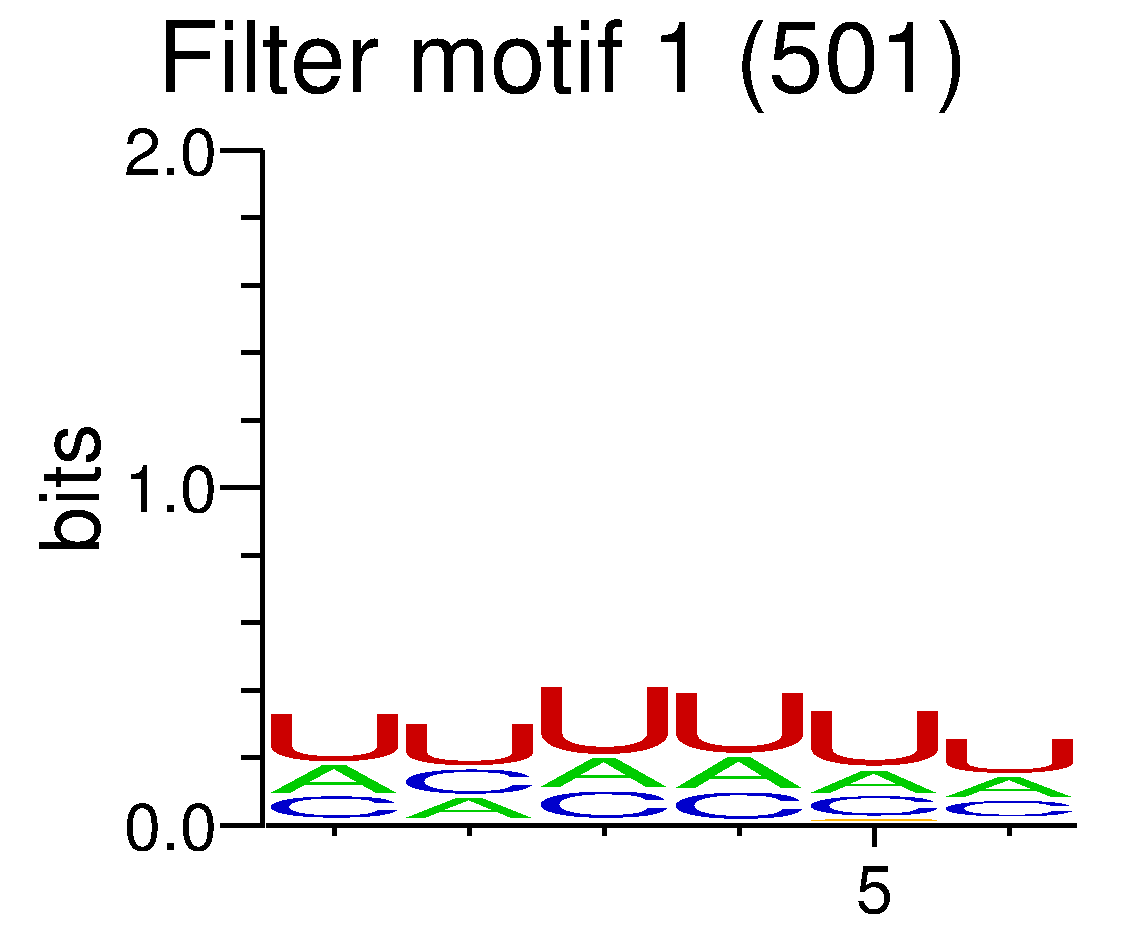

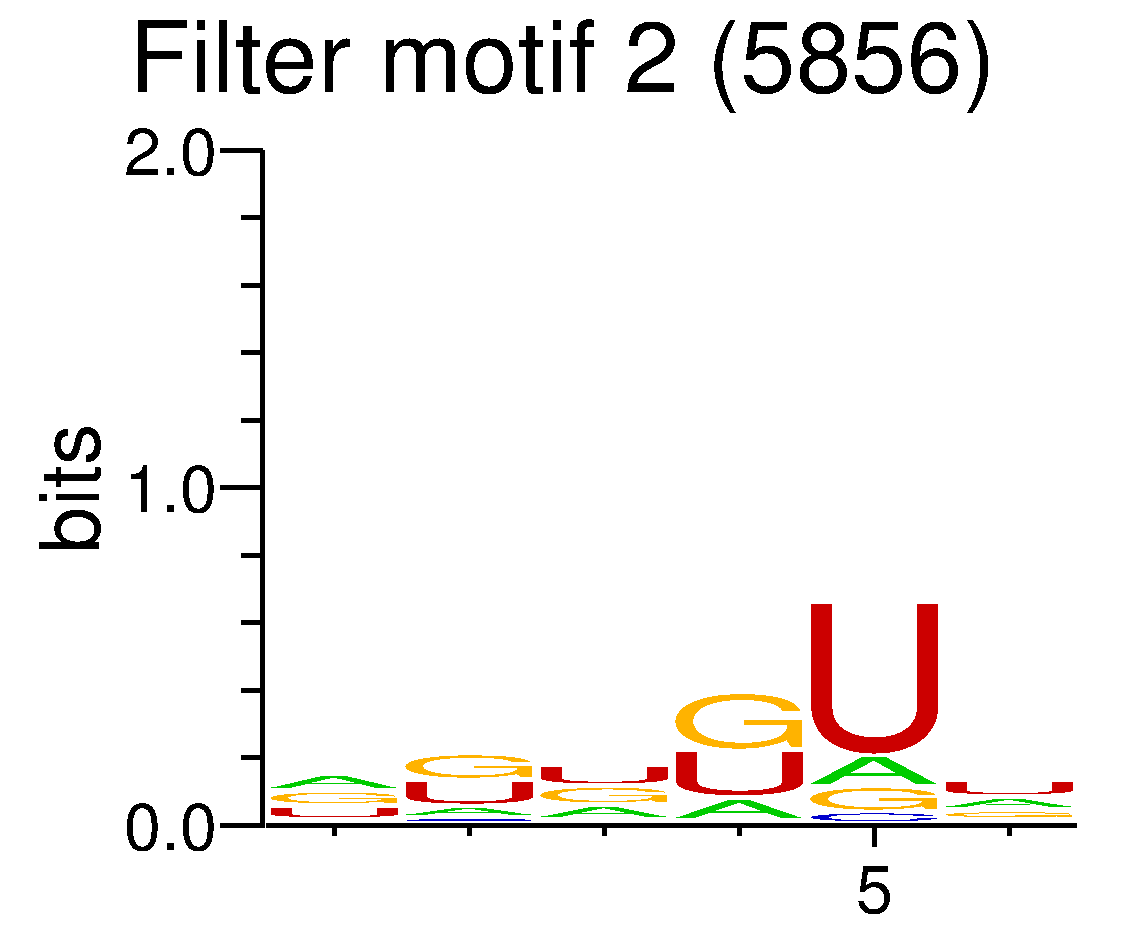

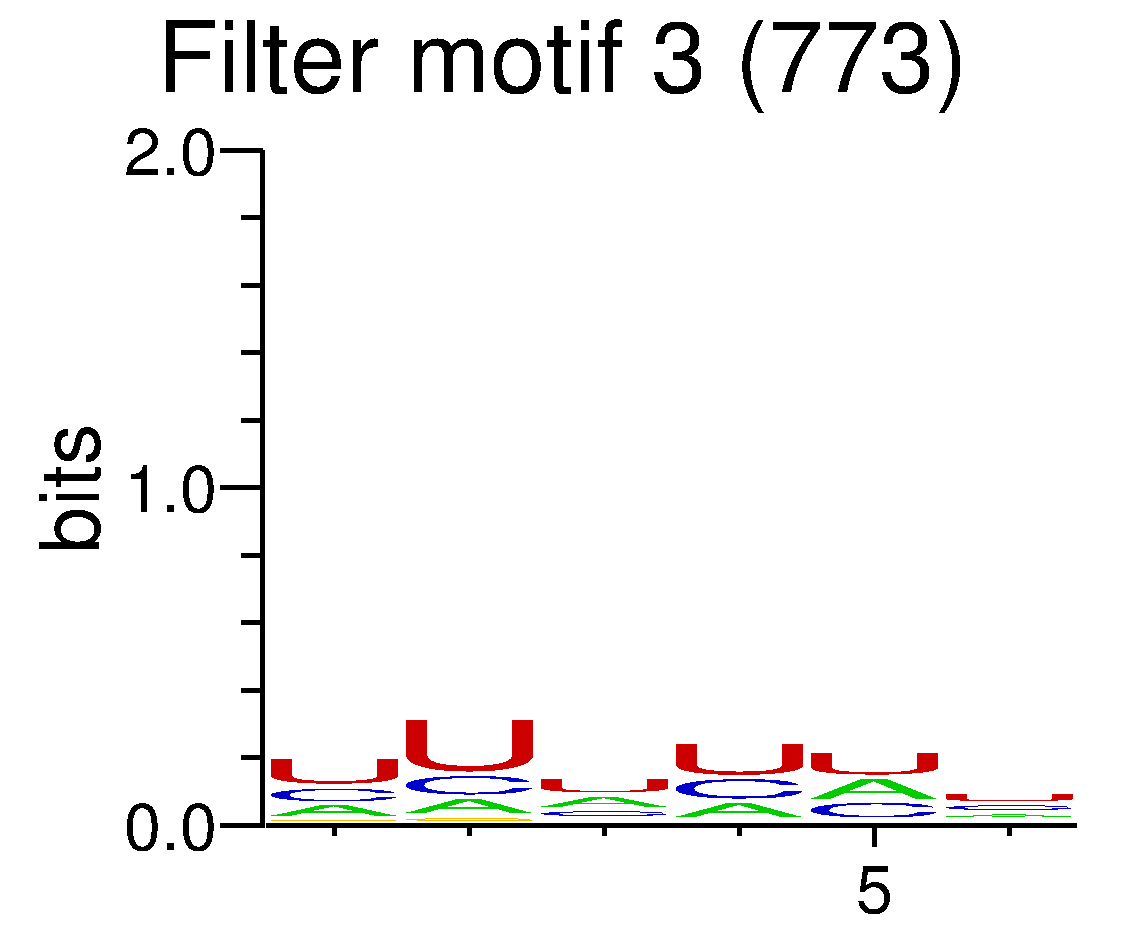

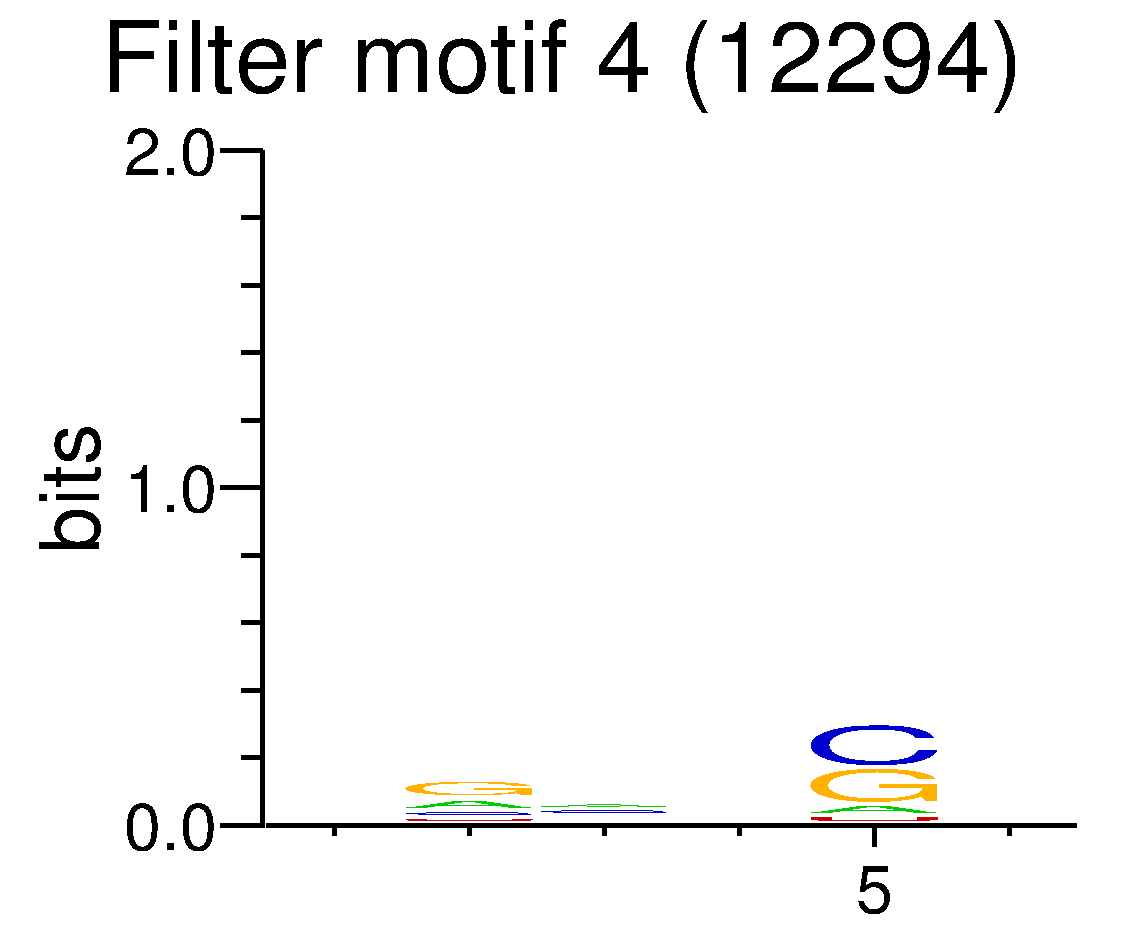

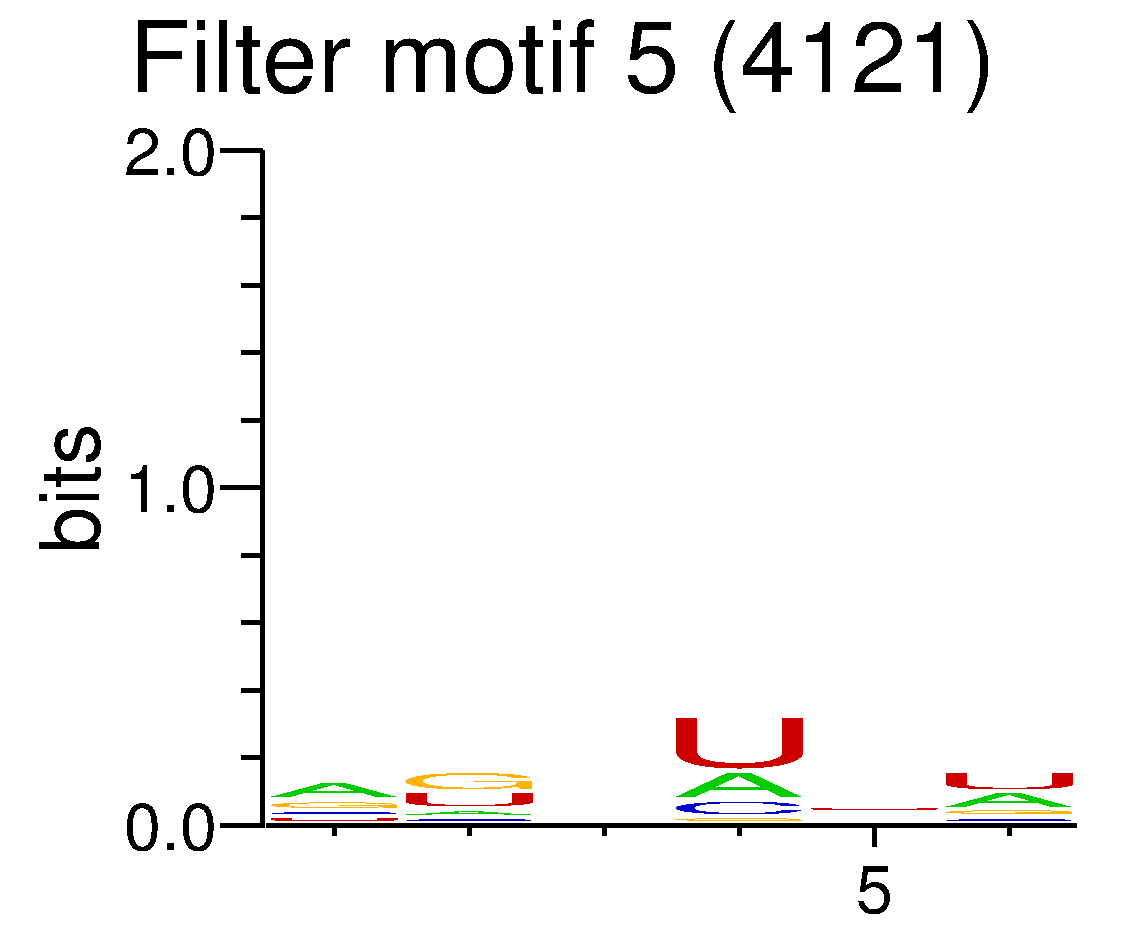

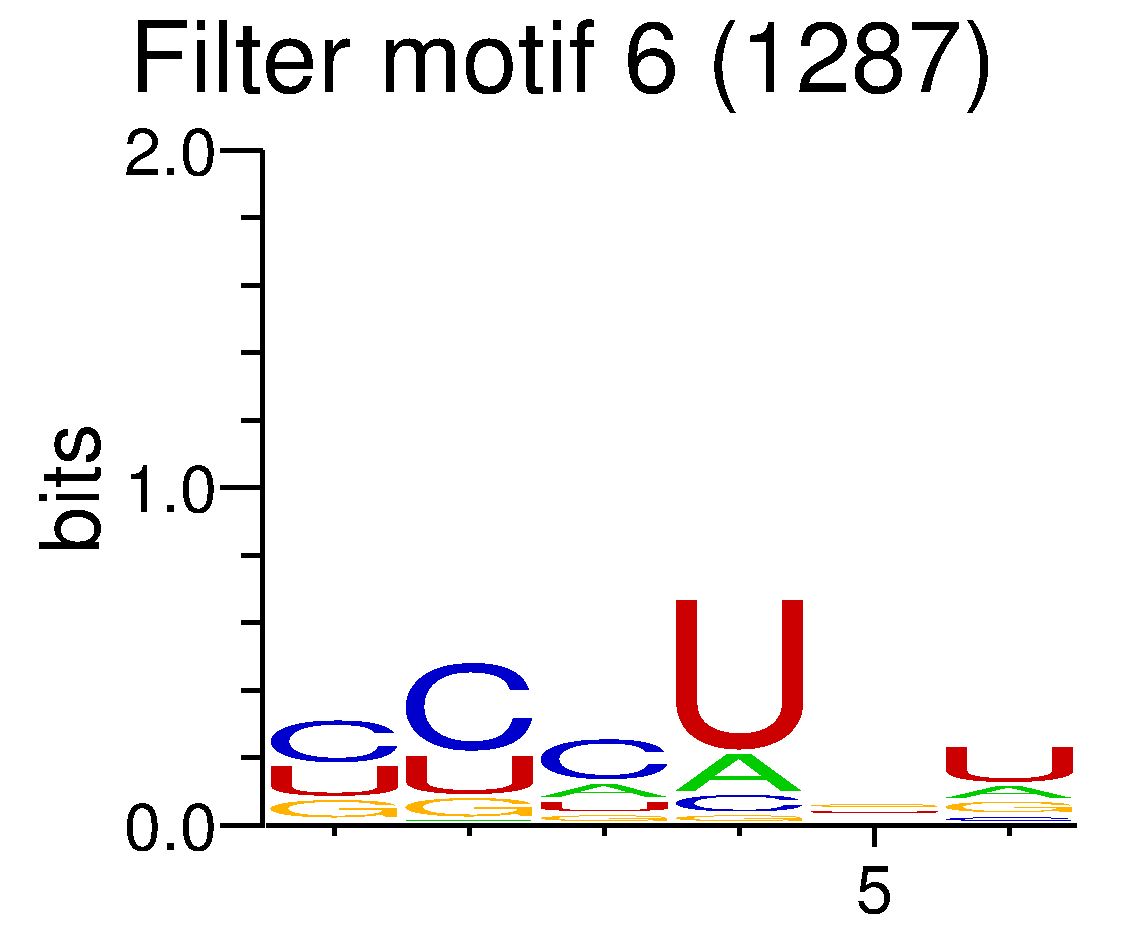

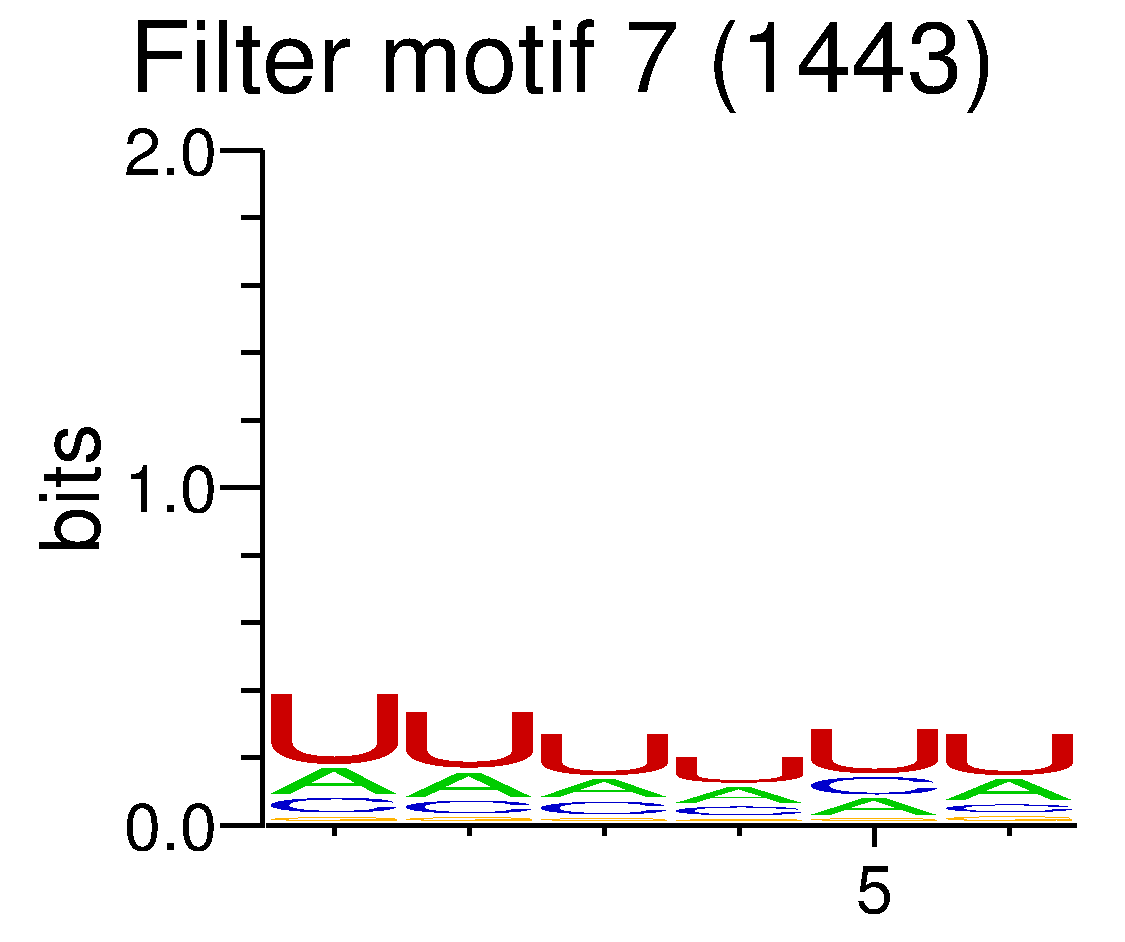

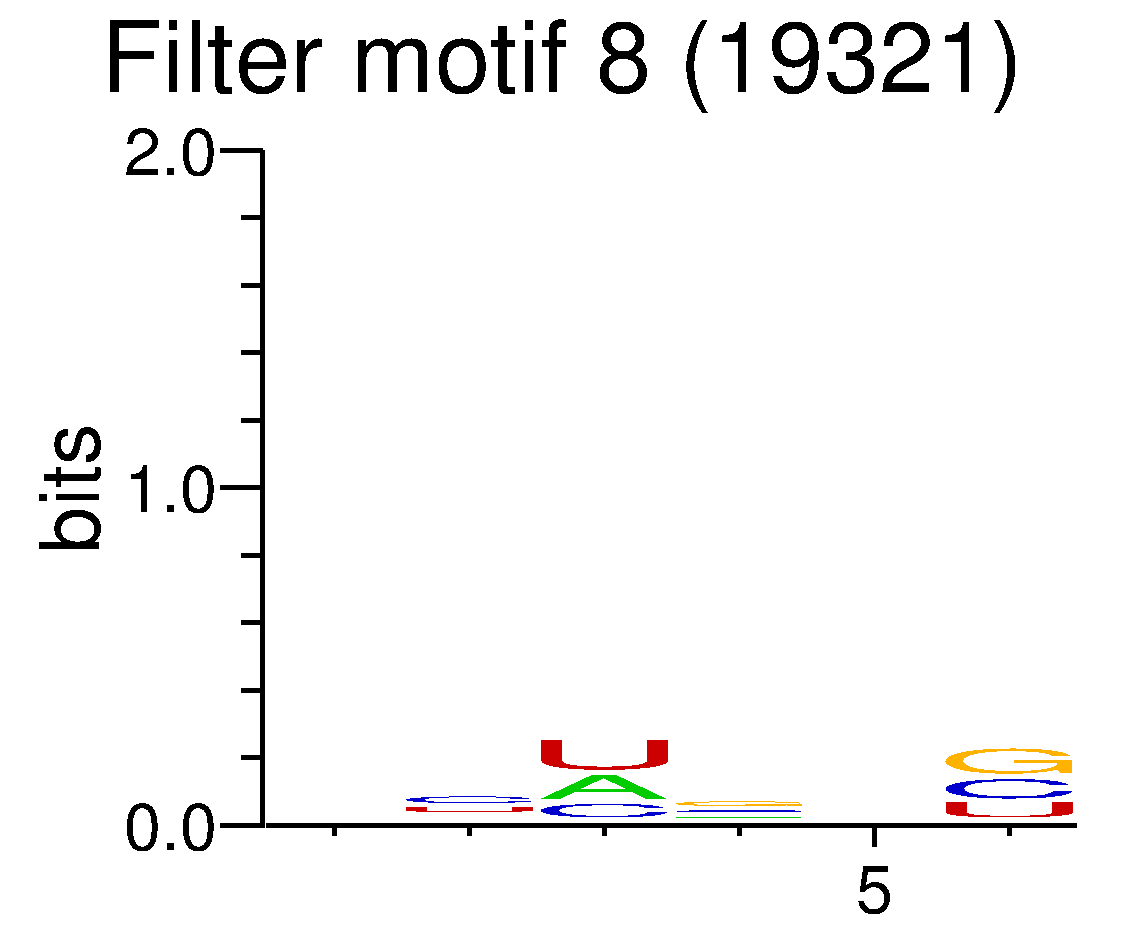

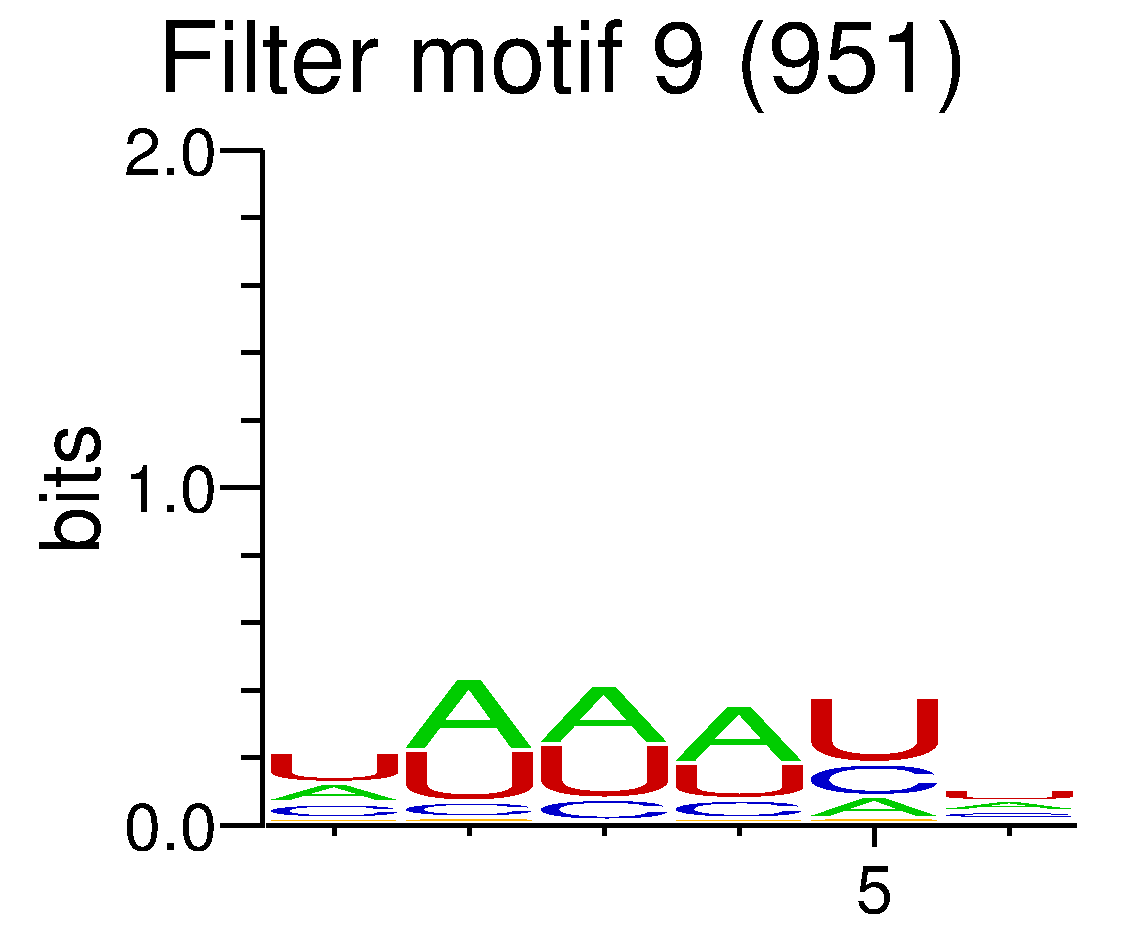

In [23]:
for protein in protein_list:
    print(protein)
    for filter_number in range(10):
        display(Image(f"results/filter_motifs/{protein}/motif{filter_number}.png"))

In [4]:
import h5py
for protein in protein_list:
    #Create a new set for a protein in h5py file  
    with h5py.File("results/set_0/{}/saliency.h5".format(protein), "w") as f:
        dset = f.create_dataset(protein, dtype="f", shape=(0, 101) , maxshape=(None, 101), chunks=(1, 101))
        # print(f.keys())

<KeysViewHDF5 ['1_PARCLIP_AGO1234_hg19']>


In [14]:
# Run saliency calculation in batch mode
!./saliency_script

In [11]:
# Saliency motifs generated on saliency of whole positive data set for each protein.


def onehot_to_seq(encoded_sequence):
    nucleotide = {0: "A", 1: "U", 2: "G", 3: "C"}
    sequence = []
    for entry in encoded_sequence:
        i = 0
        for nuc in entry:
            if nuc == 1:
                sequence.append(nucleotide[i])
            i += 1
    return sequence


# Sum of gradients across all layers saved under protein name.
for protein in protein_list:
    # Load the saliency gradients dictionary for all the proteins.
    with h5py.File(f"results/set_0/{protein}/saliency.h5", "r") as f:
        dataset = f[protein]
        positive_samples = get_positive_samples(protein, "test", 0, *experiment_set)
        print(dataset)

        for f, grad in enumerate(dataset):
            if sum(grad) != 0:
                # Find the window of 7 nucletides with the highest sailency using highest sum as a measure.
                n = 101
                window_size = 7
                max_saliency_sum = 0

                # calculate sum of elements in the first window
                for i in range(window_size):
                    # print(grad[i])
                    max_saliency_sum += grad[i]
                    # print(max_saliency_sum)

                curr_sum = max_saliency_sum
                position = 7
                # calculate sum for each next position by adding the value of current position and removing the value of the first position of previous window. Position is the index of the last element that gives highest sum.
                for i in range(window_size, n):

                    curr_sum += grad[i] - grad[i - window_size]
                    if curr_sum > max_saliency_sum:
                        position = i
                    max_saliency_sum = max(max_saliency_sum, curr_sum)

                seed_input = positive_samples[f, :, :]

                # After obtainig the position value of the last nucleotide in the 7 nucleotides window, we extract features from the input matrix.
                highest_saliency_motif = [
                    seed_input[i, :] for i in range(position - 7, position)
                ]
                oh_motif = np.array(highest_saliency_motif)[:, 0:4]
                motif_seq = onehot_to_seq(oh_motif)

                with open(f"results/set_0/{protein}/saliency_motifs.txt", "a",) as m:
                    m.write("{}\t{}\n".format(f + 1, "".join(motif_seq)))


<HDF5 dataset "1_PARCLIP_AGO1234_hg19": shape (50, 101), type "<f4">


1_PARCLIP_AGO1234_hg19


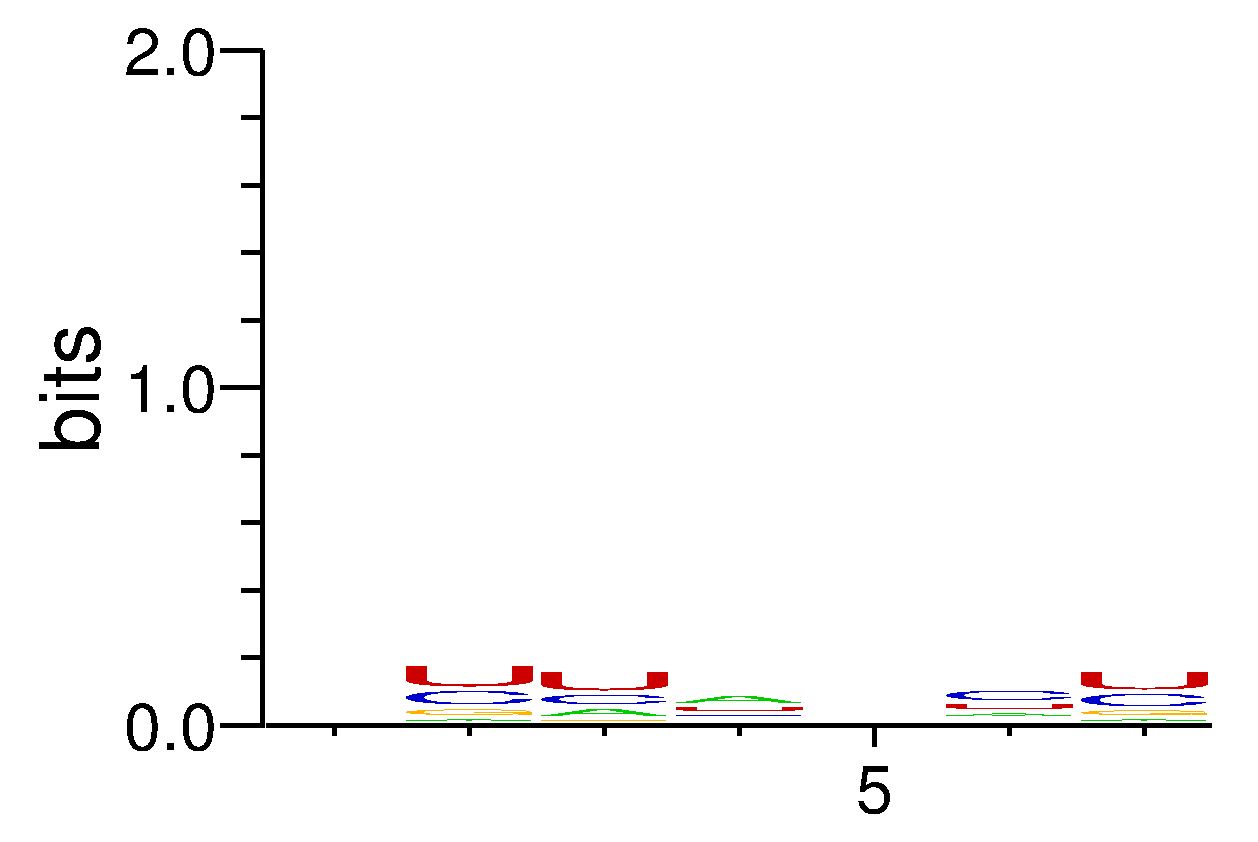

In [12]:

for protein in protein_list:
    print (protein)
    cmd = (f"weblogo -f results/set_0/{protein}/saliency_motifs.txt -D table -F png_print -o results/set_0/{protein}/saliency.png -F png_print  -P '' --errorbars NO --show-xaxis YES --show-yaxis YES --size large -A rna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U'")

    os.system(cmd)
    display(Image(f"results/set_0/{protein}/saliency.png"))

In [17]:
jaspar_file = open("results/first_layer_filters.jaspar", "w")
d_source = "SEQ"
for protein in protein_list:
    print(protein)

    # Load the model and weights.
    with open(f"results/set_0/{protein}/model.json", "r") as json_file:
        json = json_file.read()
        model = model_from_json(json)
        model.load_weights(f"results/set_0/{protein}/weights.h5")
        filters, biases = model.layers[0].get_weights()

        filter_min, filter_max = filters.min(), filters.max()
        # normalize filter values
        filters = (filters - filter_min) / (filter_max - filter_min)

        nucleotides = {0: "A", 1: "T", 2: "G", 3: "C"}
        d_sources_filters = {
            "SEQ": filters[:, 0:4, :],
            "RNA": filters[:, 4:5, :],
            "RG": filters[:, 5:10, :],
            "CLIP": filters[:, 10:36, :],
        }
        for filter_num in range(10):
            fil = (d_sources_filters["SEQ"])[:, :, filter_num]
            jaspar_file.writelines(
                ">filter " + "{}_{}_{}".format(d_source, protein, filter_num) + "\n"
            )
            for i, nucleotide in enumerate(fil.T):
                jaspar_file.writelines(
                    nucleotides[i]
                    + " [ "
                    + " ".join(map(str, list(nucleotide)))
                    + " ]\n"
                )
jaspar_file.close()

1_PARCLIP_AGO1234_hg19


In [19]:
%run filter_logo

['/home/alovse/project/RNAp-learn/refactored', '/home/alovse/.vscode-server/extensions/ms-toolsai.jupyter-2021.6.832593372/pythonFiles', '/home/alovse/.vscode-server/extensions/ms-toolsai.jupyter-2021.6.832593372/pythonFiles/lib/python', '/home/alovse/miniconda3/envs/rnap3/lib/python36.zip', '/home/alovse/miniconda3/envs/rnap3/lib/python3.6', '/home/alovse/miniconda3/envs/rnap3/lib/python3.6/lib-dynload', '', '/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages', '/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/IPython/extensions', '/home/alovse/.ipython']


In [ ]:
for protein in protein_list:
    print(protein)
    for filter_number in range(10):
        display(Image(f"results/filters/{protein}/motif{filter_number}.png"))